Alexsandro Oliveira Alexandrino (RA192804)

Enoque Alves de Castro Neto (RA230211)

Klairton de Lima Brito (RA188948)

# Introduction

In the field of robotics, one important task is to generate a location map of the environment. To generate this map the robot needs to use a variety of sensors, such as lasers and sonars, to collect point clouds that represent objects placed in the environment. However, only the information of the sensors is not enough, since they give positions related to the robot reference frame. Knowing this, we also need to estimate the position and orientation of the robot in the global frame to draw a good map of the environment. Building a location map helps the robot to navigate and to communicate with other robots since different robots need the same location reference (global reference) to locate properly in relation to each other. Due to memory constraints, storing all the cloud points is expensive. So, another step in this process is to use feature extraction algorithms to represent objects like lines and, consequently, we can use much less memory. 

In this work, we focus on the study of the Pioneer robot's kinematic model and sensors to explore and build a location map of an office environment. For this, we used the V-REP simulator, which is described next. We also aimed to compare the odometry of our robot with the simulator's ground truth trajectory. For feature extraction, we used the RANSAC algorithm to transform the point clouds in lines. And, we used the robot's camera to detect doors in the environment and represent these doors on the map.

## The Simulator

The development of a robot is a complex and multidisciplinary task and robot simulation platforms are very helpful when modeling a robot. These platforms aim to simulate many aspects of a robot in a virtual environment, including movement and use of sensors. Furthermore, simulators help to decrease the cost of hardware, since algorithms can be tested without the need to build an actual robot. There are many simulators available<cite data-cite="freese2010virtual"></cite>, such as Open HRP<cite data-cite="kanehiro2004openhrp"></cite>, Gazebo<cite data-cite="koenig2004design"> </cite>, and Webots<cite data-cite="michel2004cyberbotics"></cite>.

The platform used in this work was the Virtual Robot Experimentation Platform (V-REP). The V-REP simulator tries to gather all requirements of a versatile simulation and scalable structure. Besides offering traditional features of a simulation platform, the V-REP offers built-in and ready-to-use functionalities and multiple programming approaches<cite data-cite="rohmer2013v"></cite>.

## Report Presentation

This report is organized as follows. In Section 2, we discuss related works found in the literature. In Section 3, we discuss the methodology used to develop our virtual robot. In Section 4, we present the code along with experiments. In Section 5, we discuss our results. And in Section 6, we give final remarks and suggestions for future works.


# Related Works

In the literature, many studies tried to address the problem of navigating an unknown environment a non-holonomic mobile robot. Some of them execute such a task using proximity sensors to navigate avoiding obstacles<cite data-cite="li2017navigation"></cite> or using laser sensors<cite data-cite="forsberg1995mobile"></cite>. More complex algorithms using Fuzzy Logic are also found to execute the navigation of a robot<cite data-cite="shi2004fuzzy"></cite>.

Besides avoiding obstacles, to build a map that explores well the environment, the robot must be able to detect doors. For such, there are works which use Hough Transform to extract features of doors to help detect them<cite data-cite="tian2010computer"></cite>.

To collect the point clouds referent to the objects, we can use the sonar sensor of the laser scanner<cite data-cite="xu2002map"></cite><cite data-cite="thrun2002robotic"></cite>. A good practice is to fuse these sensors to have better results.

# Proposed Work and Methodology

Our solution used a variety of sensors, such as sonar, laser scanner, camera, and gyroscope, to help navigate and construct the location map. Our goals are to:

1. Navigate the environment avoiding obstacles and searching for doors.
2. Calculate the trajectory using odometry.
3. Calculate the trajectory using the simulator's ground truth.
4. Create a location map using the sonar sensor and ground truth information.
5. Create a location map using the laser sensor and ground truth information.
6. Create a location map using the laser sensor and odometry information.
7. Feature extraction of the point clouds.
8. Add in the location map information regarding doors locations.

Initially, we modify the scene to include all necessary sensors in the robot. Them, we understood and implemented the kinematic model and functions to change a point to the reference frame to the global frame (and vice-versa) using the material available in the course website. Next, we build functions to use the sensors and an algorithm no navigate the environment. To avoid obstacles, it was first used the data from the sonar sensor. Later on, we used the data from the laser sensor which resulted in better detection of obstacles.

To build the location map, it was used data from the sonar sensor and the laser sensor separately. 
For the detection of doors, we initially attempted to use the Hough Transform, which did not bring good results. So, we modified the color of the doors to help identify them using a color detection algorithm. With this, we proposed a navigation algorithm which has its pseudo-code described next.

- while "Desired iterations not reached":
- - if "Door detected" and "There is no obstacle":
- - -   "Align the door to the robot front"
- -  if "Obstacle detected":
- - -    "Check if the right or left side is free"
- - -    "Rotate until finding a free path."
- -  "Go forward"
- - "Add a new iteration"

Finally, for the feature extraction, we used various iterations of the RANSAC algorithm, which gave fair results.

### Merging Sensors
Detecting obstacles, determining good trajectories, and differing a door from an obstacle can sound like simple tasks. To simulate these behaviors, that are natural for humans, we had to use different sensors and, in some cases, we fused the information obtained by them. Following we describe the sensors used to perform these tasks:

- Obstacle detection: Initially, we used just the six frontal sonars to detect the objects located in front of the robot. Later, we realized that sonars are not so precise considering corners and close distances. To circumvent this problem, we decided to combine the information provided by the laser and sonars. The strategy used was to capture the frontal distance provided by laser (60º) and, if some obstacle was detected, we used the lateral sonars to choose the best direction to rotate the robot and avoid the obstacle.
- Doors detection: For this task, we combined the information provided by the laser and the camera. We applied a mask in the image generated by the camera and estimated if the robot was aligned with the door or not considering the centroid of the mask. The laser was used to determine if the door was far away or not.
- Trajectory: We combined the camera, laser, and sonar to determine a clear path for the robot. Besides, we incorporate a gyroscope to improve the rotation and odometry.


# Robot's code and Experiments

To implement the features proposed, we use the libraries opencv-python, skimage, and sklearn. We also used the files vrep.py and robot.py, which were provided in the course. The class robot.py was altered to include several methods to rotate the robot and to read the gyroscope data, these modifications are described later in details. Next, we present the code which imports libraries and files used by the algorithms. In the folder '../src', we expect the files robot.py (with the added methods) and utils.py. In the folder '../lib', we expect the files vrep.py, vrepConst.py, removeApi.so. The scene used in the experiments is presented in the folder scenes with the name p3xd.ttt. Also, remember to start the simulator before proceeding. 

In [1]:
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import random
import sys, time, cv2
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn import linear_model, datasets
from skimage import io
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data
from skimage.transform import probabilistic_hough_line
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import img_as_ubyte

sys.path.insert(0, '../src')
from robot import Robot
from utils import *

Next, we present the added methods in the robot.py file. These methods are used to read the gyroscope information and to rotate the robot. The methods which rotate the robot also updated the robot's angle, which is used in the odometry.

```python
    #These methods are implemented in robot.py and are loaded before by the line 'from robot import Robot
' 
    def read_gyro_sensor(self):
		"""
			Reads the robot gyroscope orientation.
			Returns:
				orientation: Array with the euler angles (alpha, beta and gamma).
		"""
		res, orientation = vrep.simxGetObjectOrientation(self.clientID, self.gyro_handle, -1, vrep.simx_opmode_streaming)
		while(res != vrep.simx_return_ok):
			res, orientation = vrep.simxGetObjectOrientation(self.clientID, self.gyro_handle, -1, vrep.simx_opmode_streaming)

		return orientation

	def rotate(self, degrees, error = (2 * (math.pi / 2 / 180 )), method = "gyroscope"):
		if method == "odometry":
			self.odometry_rotate(degrees, error)
		elif method == "gyroscope":
			self.gyro_rotate(degrees, error)
		elif method == "ground_truth":
			self.true_rotate(degrees, error)
		else:
			print("Error - Undefined method to rotate.")

	# Rotate the robot considering odometry
	def odometry_rotate(self, degrees, error = ((2 * math.pi) / 360)):
		clockwise = degrees < 0 # rotation 
		l = 0.335 / 2 # distance betwwen the wheels divided by two
		c = (2 * math.pi * l)  # robot circumference
		degrees = (abs(degrees) / math.pi) * 180 # degrees in range 0-360+
		spins = (degrees * c / 360) / (2 * math.pi * self.WHEEL_RADIUS) # linear distance divided by the wheel circumference
		t = (spins * 360) / (180 / math.pi) # time to perform the spins considering 1 rad/sec (wheel)
		if clockwise:
			self.set_left_velocity(-1.0 / 4)
			self.set_right_velocity(1.0 / 4)
		else:
			self.set_left_velocity(1.0 / 4)
			self.set_right_velocity(-1.0 / 4)
		time.sleep(4.0 * t) # velocity 1.0/4 rad/sec
		self.stop()

	# Rotate the robot considering the gyro gamma angle on the robot.
	def gyro_rotate(self, degrees, error = ((2 * math.pi) / 360)):
		clockwise = degrees < 0 # rotation 
		a, b, g = self.read_gyro_sensor()
		origin = (g + 2 * math.pi) % (2 * math.pi)
		target = (origin - degrees + 2 * math.pi) % (2 * math.pi)
		while (target - origin + 2 * math.pi) % (2 * math.pi) > error:
			p = ((target - origin + 2 * math.pi) % (2 * math.pi)) / (2 * math.pi) * 1.0 / 16 # Proportional speed
			if clockwise:
				self.set_left_velocity(-1.0 / 16 - p)
				self.set_right_velocity(1.0 / 16 + p)
			else:
				self.set_left_velocity(1.0 / 16 + p)
				self.set_right_velocity(-1.0 / 16 - p)
			a, b, g = self.read_gyro_sensor()
			origin = (g + 2 * math.pi) % (2 * math.pi)
		self.stop()

	# Rotate the robot considering the true gamma angle on the environment.
	def true_rotate(self, degrees, error = ((2 * math.pi) / 360)):
		clockwise = degrees < 0 # rotation 
		a, b, g = self.get_current_orientation()
		origin = (g + 2 * math.pi) % (2 * math.pi)
		target = (origin - degrees + 2 * math.pi) % (2 * math.pi)
		while (target - origin + 2 * math.pi) % (2 * math.pi) > error:
			p = ((target - origin + 2 * math.pi) % (2 * math.pi)) / (2 * math.pi) * 1.0 / 16 # Proportional speed
			if clockwise:
				self.set_left_velocity(-1.0 / 16 - p)
				self.set_right_velocity(1.0 / 16 + p)
			else:
				self.set_left_velocity(1.0 / 16 + p)
				self.set_right_velocity(-1.0 / 16 - p)
			a, b, g = self.get_current_orientation()
			origin = (g + 2 * math.pi) % (2 * math.pi)
		self.stop()
```

We define the maximum number of iterations that the navigation loop will run and start variables used to store the point clouds and odometry.

In [ ]:
MAX_ITERATION = 250
iteration = 0

robot = Robot()
x, y, z = robot.get_current_position()
map_laser_odometry = []
map_laser_ground_truth = []
map_sonar_ground_truth = []
map_door_laser_ground_truth = []
odometry = [(x, y)]
ground_truth = [(x, y)]
coord_local = [x, y, z]
alpha, beta, gamma = robot.get_current_orientation()
gamma = (gamma + 2 * math.pi) % (2 * math.pi)

Before proceeding, wait for the message indicating that the Robot is connected.

Now, we present auxiliary functions used to compute the odometry and to store the point clouds.

In [7]:
# Converts angles from V-REP to standard notation
def get_alpha(alpha):
    return (alpha + 2 * math.pi) % (2 * math.pi)

# Transforms a points from the robot reference frame to the global reference frame
# We used the slides as reference to implement this function
def point_to_global(xLocal, yLocal, x, y, alpha):
   T_trans = [[1, 0, x], [0, 1, y], [0, 0, 1]]
   T_rot = [[math.cos(alpha), -math.sin(alpha), 0], [math.sin(alpha), math.cos(alpha),0], [0,0,1]]
   T = np.matmul(T_trans, T_rot)
   pos = np.matmul(T, np.transpose([xLocal,yLocal,1.0]))
   return pos

# We used the slides as reference to implement this function
def compute_odometry(robot):
    # Odometry
    # Using the gamma angle and wheel circumference we estimate the next stop point
    # a, b, g = robot.get_current_orientation()
    # By our strategy, our robot or rotate or is moving foward
    d = (2 * math.pi * robot.WHEEL_RADIUS) / 360 * ((180 / math.pi * 2))
    coord_local[0] = d * math.cos(gamma) + odometry[-1][0]
    coord_local[1] = d * math.sin(gamma) + odometry[-1][1]
    odometry.append(coord_local[:2])

    
def compute_ground_truth(robot):
    # Ground Truth
    x, y, z = robot.get_current_position()
    ground_truth.append((x, y))

#detects an obstacle consider a no detection dist of 0.5
def obstacle_detect_sonar(robot, sonars = [0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0], distance = 0.5):
    ultrassonic = robot.read_ultrassonic_sensors()
    detect = []
    for i in range(16):
        if sonars[i]:
            detect.append(ultrassonic[i] < distance)
        else:
            detect.append(False)
    return any(detect)

# Transforms the output from the laser scanner to include angle and distance from the robot. 
# This is used to detect obstacled.
def obstacle_detect_laser(robot, distance = 0.8):
    laser = robot.read_laser()
    data = []
    out = []
    for i in range(int(len(laser) / 3)):
        data.append((laser[3 * i], laser[3 * i + 1]))
    for x, y in data:
        if x >= 0:
            if y >= 0:
                d = (x**2 + y**2)**(1.0/2)
                alpha = math.asin(y / d) * 180/math.pi
                out.append((x, y, d, alpha))
            else:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(x / d) + math.pi + math.pi / 2) * 180/math.pi
                out.append((x, y, d, alpha))
        else:
            if y >= 0:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(abs(x) / d) + math.pi / 2) * 180/math.pi
                out.append((x, y, d, alpha))
            else:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(abs(y) / d) + math.pi) * 180/math.pi
                out.append((x, y, d, alpha))
    for x, y, d, alpha in out:
        if (alpha < 30 or alpha > 330) and d < distance:
            return True
    return False

#capture point clouds using the laser sensor
def laser_capture(robot):
    data = []
    x, y, z = robot.get_current_position()
    a, b, g = robot.get_current_orientation()
    laser = robot.read_laser()
    for i in range(int(len(laser) / 3)):
        p = point_to_global(laser[3 * i], laser[3 * i + 1], x, y, get_alpha(g))
        map_laser_ground_truth.append((p[0], p[1]))
        p = point_to_global(laser[3 * i], laser[3 * i + 1], coord_local[0], coord_local[1], gamma)
        map_laser_odometry.append((p[0], p[1]))

#capture point clouds using the sonar sensor
def sonar_capture(robot):
    # angles of each sonar
    sonar_angles = [90,50,30,10,-10,-30,-50,-90,-90,-130,-150,-170,170,150,130,90]
    NO_DETECTION_DIST = 5.0
    data = []
    x, y, z = robot.get_current_position()
    a, b, g = robot.get_current_orientation()
    dist = robot.read_ultrassonic_sensors()
    for i in range(0,16):
        if dist[i] < NO_DETECTION_DIST:
            gamma = get_alpha(get_alpha(g) + get_alpha(math.radians(sonar_angles[i])))
            # using formula of slide Locomotion II page 39
            # 0.0975 is the robot radius
            px = (x +((dist[i]+0.0975)*math.cos(gamma)))
            py = (y +((dist[i]+0.0975)*math.sin(gamma)))
            map_sonar_ground_truth.append((px, py))


First, we attempt to use Hough Transform with Canny Edges to detect doors, since our navigation algorithm relies on this. However, we were not able to differentiate doors from cabinets, which led us to try a new approach. In the images generated by the code below, we can observe that these are high noise 

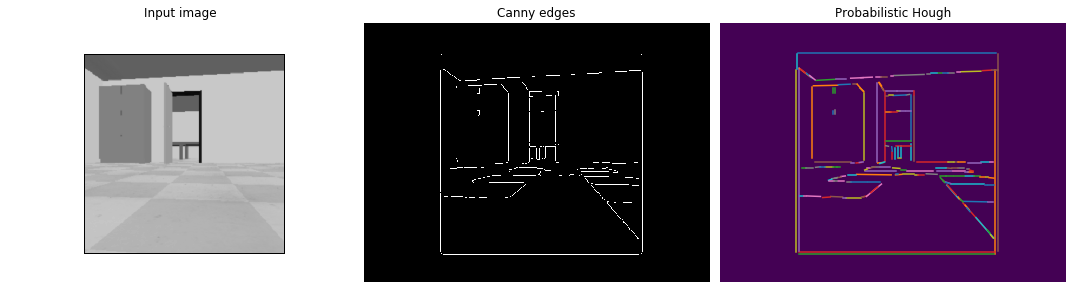

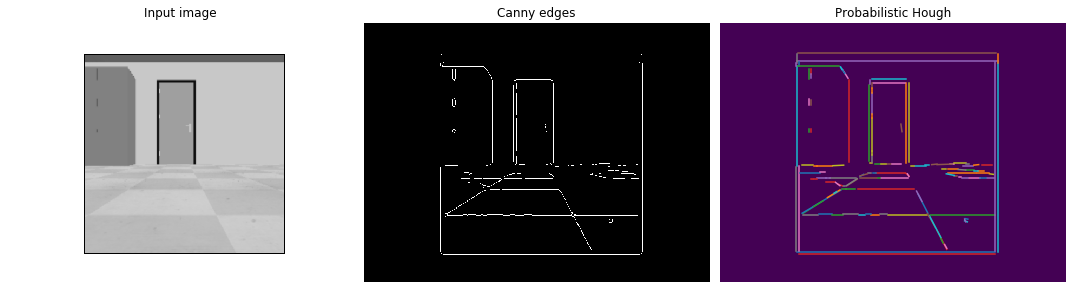

In [2]:
import numpy as np
from skimage import io
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data
from skimage.transform import probabilistic_hough_line
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage import img_as_ubyte

def extract_lines(img_name):
    image = io.imread(img_name, flatten=True)
    image = img_as_ubyte(image)
    edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
                                    line_gap=3)

    # Generating figure 2
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')

    ax[1].imshow(edges, cmap=cm.gray)
    ax[1].set_title('Canny edges')

    ax[2].imshow(edges * 0)
    for line in lines:
        p0, p1 = line
        # print(p0,p1)
        ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_title('Probabilistic Hough')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()

########################### PLOT ###############################
extract_lines("door_1.png")
extract_lines("door_2.png")


Our next approach was to change the color of the doors and use the opencv library to help locate the presence of the blue color in the image from the camera. The code below shows an image of a door and the same image after the mask is applied. These images were collected during our experiments.

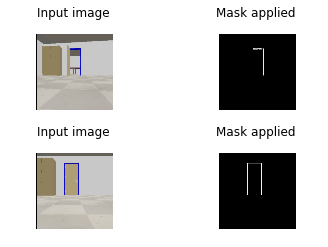

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(2, 2)
ax = axes.ravel()

ax[0].imshow(mpimg.imread('door_1.png'))
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(mpimg.imread('door_1_mask.png'))
ax[1].set_title('Mask applied')
ax[1].set_axis_off()

ax[2].imshow(mpimg.imread('door_2.png'))
ax[2].set_title('Input image')
ax[2].set_axis_off()

ax[3].imshow(mpimg.imread('door_2_mask.png'))
ax[3].set_title('Mask applied')
ax[3].set_axis_off()

plt.show()

The next functions are used for the door detection and estimation of door position.

In [ ]:

# compute the centroid of a collection of points
def compute_centroid(points):
    c_x = 0.0
    c_y = 0.0
    for x, y in points:
        c_x += x
        c_y += y
    return (c_x / len(points), c_y / len(points))

# uses the vision sensor to detect if the color blue is presented, this indicates the presence of an door. 
def door_detect(robot):
    resolution, raw_img = robot.read_vision_sensor()
    image = vrep2array(raw_img, resolution)
    lower = np.array((0, 0, 180), dtype = "uint8")
    upper = np.array((35, 35, 255), dtype = "uint8")
    mask = cv2.inRange(image, lower, upper)
    points = []
    for i in range(len(mask) - 1, -1, -1):
        for j in range(0, len(mask[i])):
            if mask[i][j] != 0:
                points.append((j, i))
    return (len(points) > 400, points)


# Once we detect that the robot is in front of the door, this function is called to calculate an estimate
# position of the door to be included in the location map. 
# For this, we get all points from the scanner that are in an angle between 0 and 30 and between 330 and 360, 
# and them we calculate the centroid of these points.
def door_scan(robot):
    laser = robot.read_laser()
    data = []
    out = []
    for i in range(int(len(laser) / 3)):
        data.append((laser[3 * i], laser[3 * i + 1]))
    for x, y in data:
        if x >= 0:
            if y >= 0:
                d = (x**2 + y**2)**(1.0/2)
                alpha = math.asin(y / d) * 180/math.pi
                out.append((x, y, d, alpha))
            else:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(x / d) + math.pi + math.pi / 2) * 180/math.pi
                out.append((x, y, d, alpha))
        else:
            if y >= 0:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(abs(x) / d) + math.pi / 2) * 180/math.pi
                out.append((x, y, d, alpha))
            else:
                d = (x**2 + y**2)**(1.0/2)
                alpha = (math.asin(abs(y) / d) + math.pi) * 180/math.pi
                out.append((x, y, d, alpha))
    v = []
    for x_local, y_local, d, alpha in out:
        if (alpha < 30 or alpha > 330) and d < 2:
            x, y, z = robot.get_current_position()
            a, b, g = robot.get_current_orientation()
            p = point_to_global(x_local, y_local, x, y, get_alpha(g))
            v.append((p[0], p[1]))
    if len(v):
        map_door_laser_ground_truth.append(compute_centroid(v))


Now, we present the main loop. This code is responsible for implementing the navigation of the robot along with the calls for sensors readings.

In [ ]:
# Initial map
laser_capture(robot)
sonar_capture(robot)

while iteration < MAX_ITERATION:

    # First, try to identify a possible door with clear path using the frontal camera and sonars
    door, points = door_detect(robot)
    while door and not obstacle_detect_laser(robot, distance=1.0) and iteration < MAX_ITERATION:
        c_x, c_y = compute_centroid(points)
        if c_x < 118:
            robot.rotate((-5 * (2 * math.pi) / 360)) # Rotate ~5 degrees
            gamma = (gamma + (5 * (math.pi / 180)) + (2 * math.pi)) % (2 * math.pi)
            print("Camera - Rotating...")
            print("Odometry Gamma:", gamma * (180 / math.pi))
            print("Ground Truth Gamma:", get_alpha(robot.get_current_orientation()[2]) * (180 / math.pi))
        elif c_x > 138:
            robot.rotate((5 * (2 * math.pi) / 360)) # Rotate ~-5 degrees
            gamma = (gamma + (-5 * (math.pi / 180)) + (2 * math.pi)) % (2 * math.pi)
            print("Camera - Rotating...")
            print("Odometry Gamma:", gamma * (180 / math.pi))
            print("Ground Truth Gamma:", get_alpha(robot.get_current_orientation()[2]) * (180 / math.pi))
        elif c_x >= 118 and c_x <= 138:
            print("Iteration:", iteration, "of", MAX_ITERATION)

            # Odometry
            compute_odometry(robot)

            # The robot goes ahead for 2 seconds
            robot.set_left_velocity(1.0)
            robot.set_right_velocity(1.0)
            time.sleep(2)
            laser_capture(robot)
            sonar_capture(robot)

            # Ground Truth
            compute_ground_truth(robot)

            print("Odometry:", odometry[-1])
            print("Ground Truth:", ground_truth[-1])
            print("Odometry Gamma:", gamma * (180 / math.pi))
            print("Ground Truth Gamma:", get_alpha(robot.get_current_orientation()[2]) * (180 / math.pi))
            door_scan(robot)
            iteration += 1
        door, points = door_detect(robot)

    # Otherwise, rotate until finding a free path

    # Considering the lateral sonars, the robot will rotate clockwise or not
    sonars = [-1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,-1]
    ultrassonic = robot.read_ultrassonic_sensors()
    clockwise = 0
    for i in range(16):
        clockwise += sonars[i] * ultrassonic[i]
    if clockwise == 0:
        clockwise = random.choice([-1.0, 1.0]) # if have space on both sides, choose randomly
    else:
        clockwise = clockwise / abs(clockwise) # result: -1.0 or 1.0

    while obstacle_detect_laser(robot): # Object identified just ahead
        # Rotate the robot to find a clear path
        robot.stop()
        robot.rotate(clockwise * (15 * (math.pi / 180))) # Rotate ~15 degrees * orientation
        gamma = (gamma + (-clockwise * 15 * (math.pi / 180)) + (2 * math.pi)) % (2 * math.pi)
        print("Sonar - Rotating...")
        print("Odometry Gamma:", gamma * (180 / math.pi))
        print("Ground Truth Gamma:", get_alpha(robot.get_current_orientation()[2]) * (180 / math.pi))
        laser_capture(robot)
        sonar_capture(robot)

    print("Iteration:", iteration, "of", MAX_ITERATION)

    # Odometry
    compute_odometry(robot)

    # The robot goes ahead for 2 seconds
    robot.set_left_velocity(1.0)
    robot.set_right_velocity(1.0)
    time.sleep(2)
    laser_capture(robot)
    sonar_capture(robot)

    # Ground Truth
    compute_ground_truth(robot)

    print("Odometry:", odometry[-1])
    print("Ground Truth:", ground_truth[-1])
    print("Odometry Gamma:", gamma * (180 / math.pi))
    print("Ground Truth Gamma:", get_alpha(robot.get_current_orientation()[2]) * (180 / math.pi))
    iteration += 1

print("Simulation Finished.")
robot.stop()

# graph plot and save points
np.save("map_door_laser_ground_truth.npy", map_door_laser_ground_truth)
np.save("map_laser_ground_truth.npy", map_laser_ground_truth)
np.save("map_laser_odometry.npy", map_laser_odometry)
np.save("map_sonar_ground_truth.npy", map_sonar_ground_truth)
np.save("odometry.npy", odometry)
np.save("ground_truth.npy", ground_truth)

## Results

All collected data is saved in files with the extension .npy, so they are used to generate graphs and for feature extraction.

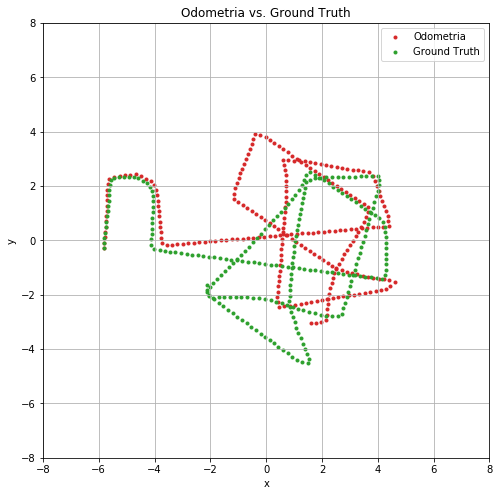

In [4]:
# coding: utf-8
from matplotlib import pyplot as plt
import numpy as np

###################PLOT 1###################

# odometry = np.load("odometry.npy")
# ground_truth = np.load("ground_truth.npy")
# files with '_last' in the name represent the data of our last full execution
odometry = np.load("odometry_last.npy") 
ground_truth = np.load("ground_truth_last.npy")

X1 = []
Y1 = []
for x,y in odometry:
    X1.append(x)
    Y1.append(y)

X2 = []
Y2 = []
for x,y in ground_truth:
    X2.append(x)
    Y2.append(y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X1, Y1, c = 'tab:red', marker = '.', label = "Odometria")
ax.scatter(X2, Y2, c = 'tab:green', marker = '.', label = "Ground Truth")
ax.grid(True)
ax.legend()
ax.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-8, 8)
plt.xlim(-8, 8) 
plt.title("Odometria vs. Ground Truth")
plt.show()

First, we used a method to rotate the robot by calculating the time needed to spin the robot in x degrees (odometry_rotate method). So, we implemented a new method that used the gyroscope data to rotate the robot in x degrees. The second method brought better results, but even with this improvement, the odometry has errors in relation to the ground truth.

In [5]:

###################PLOT 2###################

# map_sonar_ground_truth = np.load("map_sonar_ground_truth.npy")
# files with '_last' in the name represent the data of our last full execution
map_sonar_ground_truth = np.load("map_sonar_ground_truth_last.npy")

X1 = []
Y1 = []
for x,y in map_sonar_ground_truth:
    X1.append(x)
    Y1.append(y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X1, Y1, c = 'tab:red', marker = '.')
ax.grid(True)
ax.legend()
ax.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-8, 8)
plt.xlim(-8, 8) 
plt.title("Sonar point cloud (Ground Truth)")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [6]:

###################PLOT 3###################

# map_door_laser_ground_truth = np.load("map_door_laser_ground_truth.npy")
# map_laser_ground_truth = np.load("map_laser_ground_truth.npy")
# files with '_last' in the name represent the data of our last full execution
map_door_laser_ground_truth = np.load("map_door_laser_ground_truth_last.npy")
map_laser_ground_truth = np.load("map_laser_ground_truth_last.npy")

X1 = []
Y1 = []
for x,y in map_laser_ground_truth:
    X1.append(x)
    Y1.append(y)

X2 = []
Y2 = []
for x,y in map_door_laser_ground_truth:
    X2.append(x)
    Y2.append(y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X1, Y1, c = 'tab:red', marker = '.')
ax.scatter(X2, Y2, c = 'tab:blue', marker = 'x', label = "Door Region")
ax.grid(True)
ax.legend()
ax.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-8, 8)
plt.xlim(-8, 8) 
plt.title("Laser point cloud with door detection (Ground Truth)")
plt.show()


The sonar of the robot was set to detect objects with a distance of at most 1 meter, while the laser can detect objects with a distance of up to 5 meters. The laser has also much better resolution, since it can detect up to 572 points and the sonars can detect up to 16 points. Comparing the two images it is clear the advantage of the laser scanner compared with the sonar. Besides the plot of the point clouds, we also added blue points to represent regions with the presence of a door.

In [6]:
###################PLOT 4###################

# map_laser_odometry = np.load("map_laser_odometry.npy")
# files with '_last' in the name represent the data of our last full execution
map_laser_odometry = np.load("map_laser_odometry_last.npy")

X1 = []
Y1 = []
for x,y in map_laser_odometry:
    X1.append(x)
    Y1.append(y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X1, Y1, c = 'tab:red', marker = '.')
ax.grid(True)
ax.legend()
ax.legend(loc='best')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-8, 8)
plt.xlim(-8, 8) 
plt.title("Laser point cloud (Odometry)")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Above, we present the points collected with the laser that were converted to the global frame using the odometry information. Since we detect the same objects in various iterations, when it is used the ground truth information these points are converted to the same points in the global frame. However, due to errors in the odometry, each read of the same object is converted to a different point in the global frame. 

## Feature Extraction

The algorithm RANSAC can only fit one line in a collection of points. Therefore, to proper extract multiples lines from the point clouds, we divided the points into 64 regions and executed the RANSAC algorithm for the points in each region. 

In [9]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets

# data = np.load("map_laser_ground_truth.npy")
# files with '_last' in the name represent the data of our last full execution
data = np.load("map_laser_ground_truth_last.npy")
for i in range(-8, 9, 1):
        for j in range(-8, 9, 1):
#                 print("Iteration: ", i, j)
                X = []
                Y = []
                for (x,y) in data:
                        if x >= i and x <= i+1 and y >= j and y <= j+1:
                                X += [[x]]
                                Y += [[y]]

                X = np.array(X)
                Y = np.array(Y)
                if len(X) <= 10:
                        continue
                ransac = linear_model.RANSACRegressor(stop_score=0.98, random_state = 0)
                ransac.fit(X, Y)
                inlier_mask = ransac.inlier_mask_
                outlier_mask = np.logical_not(inlier_mask)

                # Predict data of estimated models
                line_X = np.arange(X.min(), X.max(), step=0.01)
                line_X = line_X.reshape(-1,1)
                line_y_ransac = ransac.predict(line_X)
                plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=2)
plt.legend(loc='lower right')
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(-8, 8)
plt.xlim(-8, 8) 
plt.show()

No handles with labels found to put in legend.


# Conclusions

Creating a location map of an unknown environment is a complex task to implement in a robot. The major issue is due to errors in the odometry, since the ground truth information is only available in a simulated environment. In a real environment, we could add checkpoints, such as Bluetooth beacons, to help the robot to locate itself in the environment and to correct or restart the odometry estimation.

To help navigation and to increase the speed for door detection, we could use machine learning techniques to improve the robot's model. Another observation is related to the difference in the quality of information collected by each sensor, since we had much better results with the laser scanner. However, there is a cost using the laser, since we ended up with a lot more points to store and, consequently, much more information to process.

### Note:
To generate a LaTeX report from this notebook just download this repost as .tex file. After that, add ```\bibliographystyle{plain}``` ```\bibliography{ref}``` and compile using pdflatex and bibtex. Remember to copy the ref.bib file to the folder with the .tex file. There are references in the introduction and related works that can only be seen when exporting the notebook as a LaTeX file.